In [589]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [590]:
def ret_victory_home(row):
    if row['goal1'] > row['goal2']:
        return 'победа'
    elif row['goal1'] < row['goal2']:
        return 'поражение'
    else:
        return 'ничья'
    
def ret_victory_guest(row):
    if row['goal1'] > row['goal2']:
        return 'поражение'
    elif row['goal1'] < row['goal2']:
        return 'победа'
    else:
        return 'ничья'

In [591]:
def get_home_game_points(row):
    if row['goal1'] > row['goal2']:
        return 3
    elif row['goal1'] < row['goal2']:
        return 0
    else:
        return 1

def get_guest_game_pints(row):
    if row['goal1'] > row['goal2']:
        return 0
    elif row['goal1'] < row['goal2']:
        return 3
    else:
        return 1

In [592]:
def get_group_table(df, group_name):   
    group_games = games_df[games_df['group'] == group_name]
    group_teams = pd.concat([group_games['team1'], group_games['team2']]).unique()
    group_table = []
    for team in group_teams:
        # Считаем таблицу "домашних" игр
        team_home_games = group_games[group_games['team1']==team]
        team_home_games['points'] = team_home_games.apply(get_home_game_points,axis=1)
        # Считаем таблицу "гостевых" игр
        team_guest_games = group_games[group_games['team2']==team]
        team_guest_games['points'] = team_guest_games.apply(get_guest_game_pints,axis=1)
        # Объединяем общую таблицу
        team_games= pd.concat([team_home_games, team_guest_games],axis=0)
        team_games['points'] = team_games['points'].astype('int')
        # Суммарные характеристики
        team_points = team_games['points'].sum()
        team_goals_scored = team_home_games['goal1'].sum() + team_guest_games['goal2'].sum()
        team_goals_missed = team_home_games['goal2'].sum() + team_guest_games['goal1'].sum()
        group_table.append([team, team_points, team_goals_scored, team_goals_missed])
    
    group_table = pd.DataFrame(group_table, columns=['team', 'points', 'goals_scored', 'goals_missed'])
    group_table['goals_diff'] = group_table['goals_scored'] - group_table['goals_missed']
    group_table = group_table.sort_values(by='points',ascending=False)
    try:
        group_table.index = [1, 2, 3, 4]
    except:
        group_table = group_table.reset_index(drop=True)
    return group_table

Загружаем таблицы

In [593]:
countries = pd.read_csv('countries.csv')
players = pd.read_csv('players.csv')
events_df = pd.read_csv('events.csv')
lineups_df = pd.read_csv('lineups.csv')
games_df = pd.read_csv('games.csv')
old_games = pd.read_csv('old_games.csv')

Правим таблицы

In [594]:
countries.columns = ['country_id', 'country']
players.columns = ['num', 'name', 'team', 'birthdate', 'pos', 'country_id']
#lineups_df.columns=['game_id','country_id','name','in','out']
lineups_df['total'] = lineups_df['out'] - lineups_df['in']
players = players.merge(countries, on='country_id')
players['birthdate'] = pd.to_datetime(players['birthdate'], format='%d-%m-%Y')
players['age'] = ((dt.datetime.now() - players['birthdate']).dt.days / 365).apply(np.floor)
old_games['date'] =  pd.to_datetime(old_games['date'], format='%d-%m-%Y')

## Предварительная статистика

In [595]:
(players.
 pivot_table(index='team', values='num', aggfunc='count').
 sort_values(by='num', ascending=False).
 head(10)
)

,num
team,
Интер Милан,13
Манчестер Сити,13
Пари Сен-Жермен,12
Реал Мадрид,12
РБ Лейпциг,11
Барселона,11
Арсенал,10
Славия (Прага),10
Байер 04,10


### Возраст игроков

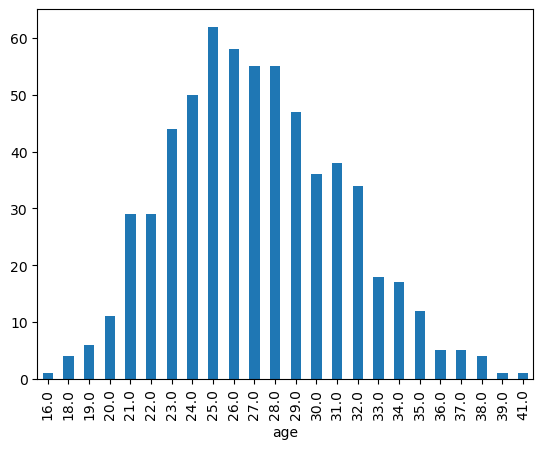

In [596]:
players.groupby('age')['num'].count().plot(kind='bar');

In [597]:
players['age'].describe()

count    622.000000
mean      27.109325
std        4.130045
min       16.000000
25%       24.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: age, dtype: float64

Самые возрастные игроки

In [598]:
players.sort_values(by='birthdate').head(5)

,num,name,team,birthdate,pos,country_id,country,age
574,3,Пепе,Порту,1983-02-26,защ,23,Португалия,41.0
589,7,Криштиану Роналду,Ан-Наср (Эр-Рияд),1985-02-05,нап,23,Португалия,39.0
143,10,Лука Модрич,Реал Мадрид,1985-09-09,поз,6,Хорватия,38.0
113,22,Хесус Навас,Севилья,1985-11-21,защ,5,Испания,38.0
544,1,Георгий Лория,Динамо Тбилиси,1986-01-27,врт,22,Грузия,38.0


Самые молодые игроки

In [599]:
players.sort_values(by='birthdate', ascending=False).head(5)

,num,name,team,birthdate,pos,country_id,country,age
127,19,Ламин Ямаль,Барселона,2007-07-13,нап,5,Испания,16.0
405,18,Варрен Заир-Эмри,Пари Сен-Жермен,2006-03-08,поз,16,Франция,18.0
464,24,Лео Сауэр,Фейеноорд,2005-12-16,нап,18,Словакия,18.0
541,24,Семих Кылычсой,Бешикташ,2005-08-15,нап,21,Турция,18.0
561,26,Габриэль Сигуа,Базель,2005-06-30,поз,22,Грузия,18.0


Самые возрастные команды

In [600]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age', ascending=False).head(5)

,age
country,
Германия,28.576923
Шотландия,28.346154
Польша,27.807692
Дания,27.769231
Швейцария,27.730769


Самые молодые команды

In [601]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age').head(5)

,age
country,
Чехия,25.500000
Турция,25.807692
Англия,26.076923
Нидерланды,26.230769
Украина,26.384615


## Статистика турнира

### Турнирные таблицы

In [602]:
from string import ascii_uppercase as alc
for i in range(6):
    print('Группа ' + alc[i])
    display(get_group_table(games_df, alc[i]))

Группа A


,team,points,goals_scored,goals_missed,goals_diff
1,Германия,3,5,1,4
2,Швейцария,3,3,1,2
3,Венгрия,0,1,3,-2
4,Шотландия,0,1,5,-4


Группа B


,team,points,goals_scored,goals_missed,goals_diff
1,Испания,3,3,0,3
2,Италия,3,2,1,1
3,Хорватия,0,0,3,-3
4,Албания,0,1,2,-1


Группа C


,team,points,goals_scored,goals_missed,goals_diff
1,Англия,3,1,0,1
2,Словения,1,1,1,0
3,Дания,1,1,1,0
4,Сербия,0,0,1,-1


Группа D


,team,points,goals_scored,goals_missed,goals_diff
1,Нидерланды,3,2,1,1
2,Франция,3,1,0,1
3,Польша,0,1,2,-1
4,Австрия,0,0,1,-1


Группа E


,team,points,goals_scored,goals_missed,goals_diff
1,Румыния,3,3,0,3
2,Словакия,3,1,0,1
3,Бельгия,0,0,1,-1
4,Украина,0,0,3,-3


Группа F


,team,points,goals_scored,goals_missed,goals_diff
1,Турция,3,3,1,2
2,Португалия,3,2,1,1
3,Грузия,0,1,3,-2
4,Чехия,0,1,2,-1


### Состав команды

In [603]:
lteam='Чехия'
# Берем id страны
lteam_id = countries[countries['country']==lteam]['country_id']
lteam_id = lteam_id.reset_index(drop=True)[0] 

lplayers = players[players['country'] == lteam] # Общий состав страны
lplayers_array = players['name']
llineup = lineups_df[lineups_df['country_id']==lteam_id] # Выходы
lteam_players = lplayers.merge(llineup, how='left')
# Голы
try:
    lgoals = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'].isin(['гол','пенальти']))]
     .pivot_table(index='name', values='event', aggfunc='count'))
    lgoals.columns = ['goals']
    lteam_players = lteam_players.merge(lgoals, on='name', how='left')
except ValueError:
    lteam_players['goals'] = 0
# Ассисты
try:
    lassist = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'пас')]
     .pivot_table(index='name', values='event', aggfunc='count'))
    lassist.columns = ['assist']
    lteam_players = lteam_players.merge(lassist, on='name', how='left')
except ValueError:
    lteam_players['assist'] = 0
# Желтые карточки
try:
    lyellows = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'желтая карточка')]
     .pivot_table(index='name', values='event', aggfunc='count'))
    lyellows.columns = ['yellows']
    lteam_players = lteam_players.merge(lyellows, on='name', how='left')
except ValueError:
    lteam_players['yellows'] = 0
# Красные карточки
try:
    lreds = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'красная карточка')]
     .pivot_table(index='name', values='event', aggfunc='count'))
    lreds.columns = ['reds']
    lreds
    lteam_players = lteam_players.merge(lreds, on='name', how='left')
except:
    lteam_players['reds'] = 0
lteam_players = lteam_players.drop(['country_id', 'country', 'game_id', 'in', 'out'], axis=1)
lteam_players = lteam_players.fillna(0)
lteam_players[['age', 'total', 'goals', 'assist', 'yellows', 'reds']] = lteam_players[['age', 'total', 'goals', 'assist', 'yellows', 'reds']].astype('int')
lteam_players.index = ['']*len(lteam_players) # Скрывает индекс
lteam_players.sort_values(by='num')

,num,name,team,birthdate,pos,age,total,goals,assist,yellows,reds
,1,Йиндржих Станек,Славия (Прага),1996-04-27,врт,28,90,0,0,0,0
,2,Давид Зима,Славия (Прага),2000-11-08,защ,23,0,0,0,0,0
,3,Томаш Голеш,Славия (Прага),1993-03-31,защ,31,89,0,0,0,0
,4,Робин Гранач,Виктория (Пльзень),2000-01-29,защ,24,90,0,0,0,0
,5,Владимир Цоуфал,Вест Хэм Юнайтед,1992-08-22,защ,31,90,0,1,0,0
,6,Мартин Витик,Спарта (Прага),2003-01-21,защ,21,0,0,0,0,0
,7,Антонин Барак,Фиорентина,1994-12-03,поз,29,11,0,0,0,0
,8,Петр Шевчик,Славия (Прага),1994-05-02,поз,30,11,0,0,0,0
,9,Адам Гложек,Байер 04,2002-07-25,нап,21,0,0,0,0,0
,10,Патрик Шик,Байер 04,1996-01-24,нап,28,60,0,0,1,0


In [604]:
countries.head()

,country_id,country
0,1,Германия
1,2,Шотландия
2,3,Венгрия
3,4,Швейцария
4,5,Испания


### Средняя результативность матча

In [605]:
games_df['total_goals'] = games_df['goal1'] + games_df['goal2']
games_df['total_goals'].describe()

count    12.000000
mean      2.833333
std       1.466804
min       1.000000
25%       1.750000
50%       3.000000
75%       3.250000
max       6.000000
Name: total_goals, dtype: float64

### Бомбардиры

In [606]:
scorers = events_df[events_df['event'].isin(['гол','пенальти'])]
scorers.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Адам Букса,1
Коди Гакпо,1
Эмре Джан,1
Франсишку Консейсан,1
Флориан Вирц,1
Фабиан Руис,1
Рэзван Марин,1
Николо Барелла,1
Николае Станчу,1


### Ассистены

In [607]:
assisters = events_df[events_df['event']=='пас']
assisters.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Деннис Ман,2
Натан Аке,2
Букайо Сака,1
Мишель Эбишер,1
Фабиан Руис,1
Томас Мюллер,1
Ремо Фройлер,1
Пётр Зелиньский,1
Педри,1


### Карточки

In [608]:
yellows = events_df[events_df['event']=='желтая карточка']
yellows.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Абдюлькерим Бардакджи,1
Неманья Гудель,1
Патрик Шик,1
Петар Стоянович,1
Рафаэл Леан,1
Ремо Фройлер,1
Риккардо Калафьори,1
Роберт Андрих,1
Родри,1


In [609]:
reds = events_df[events_df['event']=='красная карточка']
reds.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Райан Портеус,1


### Время игры

In [610]:
lineups_df.pivot_table(index='name', values='total', aggfunc='sum').sort_values(by='total', ascending=False).head(20)

,total
name,
Абдюлькерим Бардакджи,90.0
Джордан Пикфорд,90.0
Михаил Мудрик,90.0
Джек Хендри,90.0
Милош Велькович,90.0
Джованни Ди Лоренцо,90.0
Милан Шкриньяр,90.0
Джон Стоунз,90.0
Джонатан Та,90.0


## Старые игры

**Введите названия команд**

In [611]:
team1='Португалия'
team2='Чехия'

**Игры между собой**

In [612]:
old_games.loc[((old_games['team1'] == team1) & (old_games['team2'] == team2)) 
              | ((old_games['team1'] == team2) & (old_games['team2'] == team1))].sort_values(by='date',ascending=False)

,game_id,date,team1,team2,goal1,goal2,description
610,610,2022-09-24,Чехия,Португалия,0,4,Лига наций 2022-2024 (групповой этап)
536,536,2022-06-09,Португалия,Чехия,2,0,Лига наций 2022-2024 (групповой этап)
126,126,2012-06-21,Чехия,Португалия,0,1,ЧЕ-2012 1/4 финала
135,135,2008-06-11,Чехия,Португалия,1,3,ЧЕ-2008 Группа A тур 2


**Игры домашней команды**

In [613]:
team1h_df = old_games[old_games['team1'] == team1]
team1h_df['result'] = team1h_df.apply(ret_victory_home, axis=1)
team1h_pivot = team1h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1g_df = old_games[old_games['team2'] == team1]
team1g_df['result'] = team1g_df.apply(ret_victory_guest, axis=1)
team1_df = pd.concat([team1h_df, team1g_df],axis=0)
display(team1_df.sort_values(by='date',ascending=False).head(5))
team1g_pivot = team1g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1_pivot=team1h_pivot.merge(team1g_pivot, on='result', how='outer')
team1_pivot = team1_pivot.fillna(0)
team1_pivot['total'] = team1_pivot['game_id_x'] + team1_pivot['game_id_y']
team1_pivot.columns = ['home', 'guest', 'total']
team1_pivot[['home', 'guest', 'total']] = team1_pivot[['home', 'guest', 'total']].astype('int')
team1_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
392,392,2023-11-19,Португалия,Исландия,2,0,квалификация ЧЕ-2024 группа J,победа
390,390,2023-11-16,Лихтенштейн,Португалия,0,2,квалификация ЧЕ-2024 группа J,победа
387,387,2023-10-16,Босния и Герцеговина,Португалия,0,5,квалификация ЧЕ-2024 группа J,победа
383,383,2023-10-13,Португалия,Словакия,3,2,квалификация ЧЕ-2024 группа J,победа
379,379,2023-09-11,Португалия,Люксембург,9,0,квалификация ЧЕ-2024 группа J,победа


,home,guest,total
result,,,
ничья,4,3,7
победа,11,11,22
поражение,3,4,7


**Игры гостевой команды**

In [614]:
team2h_df = old_games[old_games['team1'] == team2]
team2h_df['result'] = team2h_df.apply(ret_victory_home, axis=1)
#display(team2h_df)
team2h_pivot = team2h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2g_df = old_games[old_games['team2'] == team2]
team2g_df['result'] = team2g_df.apply(ret_victory_guest, axis=1)
#display(team2g_df)
team2_df = pd.concat([team2h_df, team2g_df],axis=0)
display(team2_df.sort_values(by='date',ascending=False).head(5))
team2g_pivot = team2g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2_pivot=team2h_pivot.merge(team2g_pivot, on='result', how='outer')
team2_pivot = team2_pivot.fillna(0)
team2_pivot['total'] = team2_pivot['game_id_x'] + team2_pivot['game_id_y']
team2_pivot.columns = ['home', 'guest', 'total']
team2_pivot[['home', 'guest', 'total']] = team2_pivot[['home', 'guest', 'total']].astype('int')
team2_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
263,263,2023-11-20,Чехия,Молдавия,3,0,квалификация ЧЕ-2024 группа E,победа
261,261,2023-11-17,Польша,Чехия,1,1,квалификация ЧЕ-2024 группа E,ничья
258,258,2023-10-15,Чехия,Фарерские острова,1,0,квалификация ЧЕ-2024 группа E,победа
257,257,2023-10-12,Албания,Чехия,3,0,квалификация ЧЕ-2024 группа E,поражение
252,252,2023-09-07,Чехия,Албания,1,1,квалификация ЧЕ-2024 группа E,ничья


,home,guest,total
result,,,
ничья,3,3,6
победа,5,5,10
поражение,6,7,13


### Разное

In [622]:
players[players['team'] =='Спарта (Прага)']

,num,name,team,birthdate,pos,country_id,country,age
196,14,Казим Лачи,Спарта (Прага),1996-01-19,поз,8,Албания,28.0
281,26,Велько Бирманчевич,Спарта (Прага),1998-03-05,поз,11,Сербия,26.0
461,17,Лукаш Гараслин,Спарта (Прага),1996-03-26,нап,18,Словакия,28.0
603,6,Мартин Витик,Спарта (Прага),2003-01-21,защ,24,Чехия,21.0
606,18,Ладислав Крейчий,Спарта (Прага),1999-04-20,защ,24,Чехия,25.0
619,11,Ян Кухта,Спарта (Прага),1997-01-08,нап,24,Чехия,27.0


In [617]:
players[players['name'].str.contains('Арда')]

,num,name,team,birthdate,pos,country_id,country,age
535,8,Арда Гюлер,Реал Мадрид,2005-02-25,нап,21,Турция,19.0
